## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/PradeepS/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/PradeepS/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [5]:
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size = 0.05)

In [6]:
print("Total Size : ",len(nltk_data))
print("Train Size : ",len(train_set))
print("Test Size : ",len(test_set))

Total Size :  3914
Train Size :  3718
Test Size :  196


In [7]:
## Tagged Words
train_tagged_words = [temp for sent in train_set for temp in sent]
len(train_tagged_words)

95461

In [8]:
#Tokenizing the train set
tokens = [pair[0] for pair in train_tagged_words]
len(tokens)

95461

In [9]:
## Vocabulary
vocab = set(tokens)
len(vocab)

12066

In [10]:
## Tags
Tag = set([pair[1] for pair in train_tagged_words])
len(Tag)

12

In [11]:
Tag

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [12]:
## Creating Tag x Vocab Metrix
tag_len = len(Tag)
vocab_len = len(vocab)
vocab_tag_matrix = np.zeros((tag_len, vocab_len))

In [13]:
vocab_tag_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
## Emission Probabilty

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_word_given_tag = len(word_given_tag_list)
    return (count_word_given_tag, count_tag)

In [15]:
## Transition Provbability 
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [17]:
# Creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

Tag_Matrix = np.zeros((len(Tag), len(Tag)), dtype='float32')
for i, t1 in enumerate(list(Tag)):
    for j, t2 in enumerate(list(Tag)): 
        Tag_Matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
Tag_Matrix

array([[8.04405883e-02, 6.90921247e-02, 7.34312413e-03, 1.46862483e-02,
        1.20827772e-01, 1.46862483e-02, 2.26969291e-02, 3.20427231e-02,
        1.33177564e-01, 3.45126837e-01, 3.07076108e-02, 1.29172236e-01],
       [1.28127644e-02, 5.43938112e-03, 3.62625404e-04, 3.50537896e-03,
        9.18651000e-03, 2.41750269e-04, 4.56908010e-02, 2.24827752e-02,
        1.72851440e-02, 3.96470428e-02, 6.39550328e-01, 2.03795478e-01],
       [5.45708947e-02, 1.19869404e-01, 4.66417900e-04, 5.97014911e-02,
        5.13059683e-02, 4.19776142e-03, 8.39552283e-03, 4.19776104e-02,
        3.59141789e-02, 1.59514919e-01, 3.47947747e-01, 1.16138063e-01],
       [3.48027833e-02, 1.00541376e-02, 5.41376648e-03, 7.34725455e-03,
        2.16550659e-02, 1.23743229e-02, 9.08739343e-02, 6.96055684e-03,
        4.09899466e-02, 4.86852288e-01, 2.11523592e-01, 7.11523592e-02],
       [1.38977980e-02, 3.22749615e-01, 7.48342951e-04, 6.92751780e-02,
        1.73187945e-02, 1.49668590e-03, 3.43168713e-02, 6.38

In [19]:
Tag_df = pd.DataFrame(Tag_Matrix, columns = list(Tag), index = list(Tag))

In [20]:
Tag_df.head()

,ADV,DET,CONJ,PRON,ADP,PRT,X,NUM,.,VERB,NOUN,ADJ
ADV,0.080441,0.069092,0.007343,0.014686,0.120828,0.014686,0.022697,0.032043,0.133178,0.345127,0.030708,0.129172
DET,0.012813,0.005439,0.000363,0.003505,0.009187,0.000242,0.045691,0.022483,0.017285,0.039647,0.639550,0.203795
CONJ,0.054571,0.119869,0.000466,0.059701,0.051306,0.004198,0.008396,0.041978,0.035914,0.159515,0.347948,0.116138
PRON,0.034803,0.010054,0.005414,0.007347,0.021655,0.012374,0.090874,0.006961,0.040990,0.486852,0.211524,0.071152
ADP,0.013898,0.322750,0.000748,0.069275,0.017319,0.001497,0.034317,0.063823,0.038807,0.008659,0.323819,0.105089


In [21]:
Tag_df.loc['.',:]

ADV     0.051769
DET     0.173764
CONJ    0.058252
PRON    0.065094
ADP     0.090754
PRT     0.002341
X       0.026830
NUM     0.080760
.       0.094265
VERB    0.089043
NOUN    0.222562
ADJ     0.044476
Name: ., dtype: float32

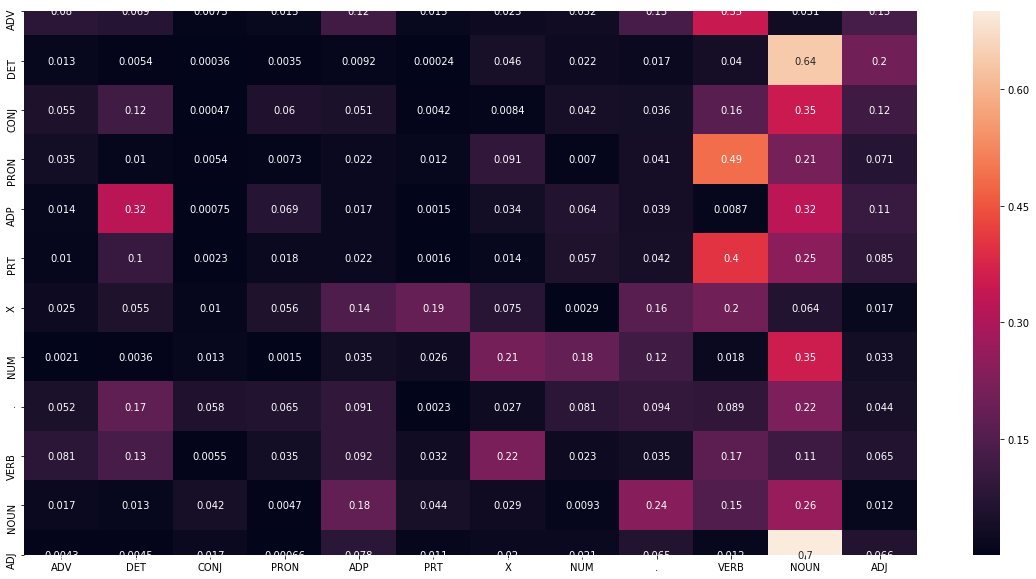

In [27]:
## Plotting heatmap 
plt.figure(figsize = (20,10))
sns.heatmap(Tag_df, annot=True)
plt.show()

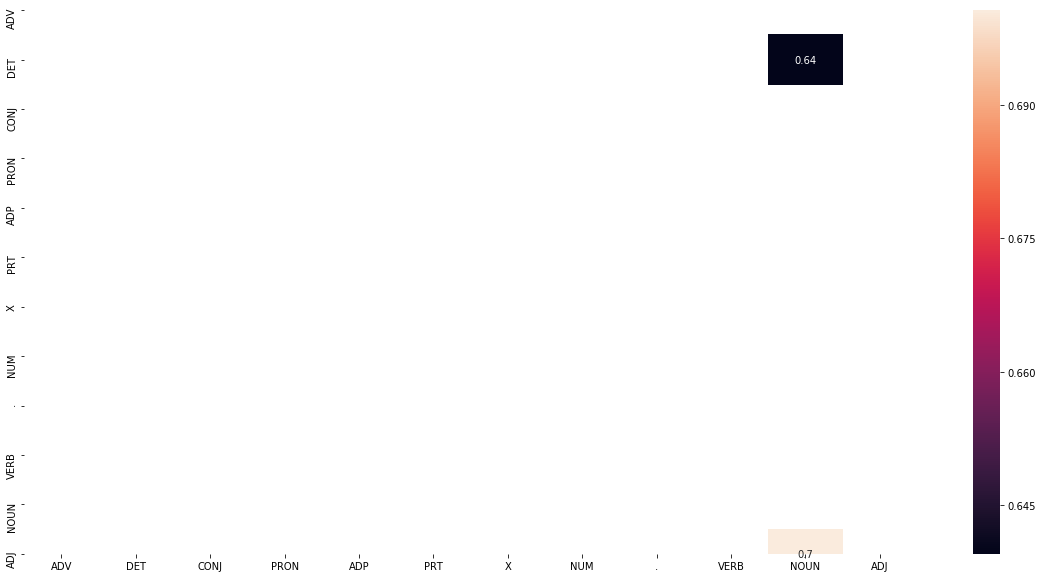

In [28]:
## Analyzing frequently occured tag
Frequent_Tag = Tag_df[Tag_df > 0.5]
plt.figure(figsize = (20,10))
sns.heatmap(Frequent_Tag, annot = True)
plt.show()

In [29]:
len(train_tagged_words)

95461

### Build the vanilla Viterbi based POS tagger

In [44]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = Tag_df.loc['.', tag]
            else:
                transition_p = Tag_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [38]:
## Running viterbi on sample sentences
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('When', 'ADV'),
  ('Ms.', 'NOUN'),
  ('Evans', 'NOUN'),
  ('took', 'VERB'),
  ('her', 'PRON'),
  ('job', 'NOUN'),
  ('*T*-1', 'X'),
  (',', '.'),
  ('several', 'ADJ'),
  ('important', 'ADJ'),
  ('divisions', 'NOUN'),
  ('that', 'DET'),
  ('*T*-2', 'X'),
  ('had', 'VERB'),
  ('reported', 'VERB'),
  ('to', 'PRT'),
  ('her', 'PRON'),
  ('predecessor', 'NOUN'),
  ('were', 'VERB'),
  ("n't", 'ADV'),
  ('included', 'VERB'),
  ('*-3', 'X'),
  ('partly', 'ADV'),
  ('because', 'ADP'),
  ('she', 'PRON'),
  ('did', 'VERB'),
  ("n't", 'ADV'),
  ('wish', 'NOUN'),
  ('*-4', 'X'),
  ('to', 'PRT'),
  ('be', 'VERB'),
  ('a', 'DET'),
  ('full-time', 'ADJ'),
  ('administrator', 'NOUN'),
  ('.', '.')],
 [('In', 'ADP'),
  ('the', 'DET'),
  ('past', 'NOUN'),
  (',', '.'),
  ('they', 'PRON'),
  ('say', 'VERB'),
  ('0', 'X'),
  ('*T*-1', 'X'),
  (',', '.'),
  ('the', 'DET'),
  ('strongest', 'ADJ'),
  ('dividend', 'NOUN'),
  ('growth', 'NOUN'),
  ('has', 'VERB'),
  ('often', 'ADV'),
  ('come', 'VERB'),
  ('

In [45]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [46]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  77.90301489830017
[('When', 'ADV'), ('Ms.', 'NOUN'), ('Evans', 'NOUN'), ('took', 'VERB'), ('her', 'PRON'), ('job', 'NOUN'), ('*T*-1', 'X'), (',', '.'), ('several', 'ADJ'), ('important', 'ADJ'), ('divisions', 'NOUN'), ('that', 'ADP'), ('*T*-2', 'X'), ('had', 'VERB'), ('reported', 'VERB'), ('to', 'PRT'), ('her', 'PRON'), ('predecessor', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('included', 'VERB'), ('*-3', 'X'), ('partly', 'ADV'), ('because', 'ADP'), ('she', 'PRON'), ('did', 'VERB'), ("n't", 'ADV'), ('wish', 'VERB'), ('*-4', 'X'), ('to', 'PRT'), ('be', 'VERB'), ('a', 'DET'), ('full-time', 'ADJ'), ('administrator', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('the', 'DET'), ('past', 'ADJ'), (',', '.'), ('they', 'PRON'), ('say', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), (',', '.'), ('the', 'DET'), ('strongest', 'ADJ'), ('dividend', 'NOUN'), ('growth', 'NOUN'), ('has', 'VERB'), ('often', 'ADV'), ('come', 'VERB'), ('at', 'ADP'), ('times', 'NOUN'), ('when', 'ADV'), ('the', 'DET')

## Evaluating tagging accuracy

In [50]:
# Checkin the Accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_accuracy = len(check)/len(tagged_seq)
print("The accuracy of the Vanilla Viterbi Algorithm is : ", viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is :  0.9326923076923077


In [51]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [52]:
incorrect_tagged_cases

[[('divisions', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [("n't", 'ADV'), (('wish', 'VERB'), ('wish', 'NOUN'))],
 [('the', 'DET'), (('past', 'ADJ'), ('past', 'NOUN'))],
 [('almost', 'ADV'), (('over', 'ADP'), ('over', 'ADJ'))],
 [('$', '.'), (('3.28', 'ADV'), ('3.28', 'NUM'))],
 [('$', '.'), (('3.16', 'ADV'), ('3.16', 'NUM'))],
 [('Japanese', 'ADJ'), (('dominance', 'ADV'), ('dominance', 'NOUN'))]]

## Solve the problem of unknown words

#### Method - 1

In [62]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_First_Method(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = Tag_df.loc['.', tag]
            else:
                transition_p = Tag_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in vocab:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [64]:
# tagging the test sentences
unknown_word_tagged_seq = Vanilla_Viterbi_First_Method(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

Vanilla_Viterbi_First_Method_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is : ", Vanilla_Viterbi_First_Method_accuracy)

The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is :  0.9423076923076923


## Lexicon and Rule-Based Models for POS Tagging

In [66]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is : ", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is :  0.9037392138063279


In [67]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [68]:
 # rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is : ", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is :  0.935953978906999


In [70]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is : ", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is :  0.9407478427612656


In [71]:
# A bigram tagger backed off by a rule based tagger.

def bigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # bigram backed up by the regex tagger
    bigram_regex_tagger = nltk.BigramTagger(train_set, backoff = regex_based_tagger)
    return bigram_regex_tagger.tag_sents([[(word)]])

#### Method 2 

In [76]:
def viterbi_Second_Method(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the bigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in vocab:
            unknown_word_tag = bigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = Tag_df.loc['.', tag]
                else:
                    transition_p = Tag_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [77]:
# tagging the test sentences
viterbi_bigram_tagged_seq = viterbi_Second_Method(test_tagged_words)

# accuracy
viterbi_bigram_word_check = [i for i, j in zip(viterbi_bigram_tagged_seq, test_run_base) if i == j]

viterbi_bigram_accuracy = len(viterbi_bigram_word_check)/len(viterbi_bigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_bigram_tagger is : ", viterbi_bigram_accuracy)

The accuracy of the viterbi_backedup_by_bigram_tagger is :  0.9615384615384616


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [125]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_run_base = [tup for sent in test_set for tup in sent]

In [127]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi_First_Method(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy1 = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm_1 Accuracy: ',accuracy1*100)

Time taken in seconds:  1254.0218687057495
Modified Viterbi Algorithm_1 Accuracy:  94.17066155321189


In [128]:
# tagging the test sentences
start = time.time()
tagged_seq = viterbi_Second_Method(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy2 = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm2 Accuracy: ',accuracy2*100)

Time taken in seconds:  37990.69959807396
Modified Viterbi Algorithm2 Accuracy:  95.57046979865773


In [112]:
# Evaluation on sample test data 
TestFile = open('sampleTextData.txt')

In [113]:
sentence = TestFile.read()

In [114]:
sample_test_sent = sentence.splitlines()
sample_test_sent

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [115]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/PradeepS/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [116]:
nltk.download('averaged_perceptron_tagger')
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sent]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/PradeepS/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [117]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]
# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]
sample_test_test_run_base

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('se

## Testing the accuracy of Vanilla Viterbi on sample test data

In [118]:
# tagging the test sentences
sample_test_tagged_seq = Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is : ", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is :  0.7513812154696132


## Testing the accuracy of Vanilla_Viterbi_First_Method on sample test data 

In [119]:
# tagging the test sentences
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_First_Method(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_First_Method on the sample test data is : ", sample_test_optimized_viterbi_accuracy)

The accuracy of the Vanilla_Viterbi_First_Method on the sample test data is :  0.8839779005524862


## Testing the accuracy of viterbi_Second_Method on sample test data 

In [120]:
# tagging the test sentences
sample_test_viterbi_bigram_tagged_seq = viterbi_Second_Method(sample_test_tagged_words)

# accuracy
sample_test_viterbi_bigram_check = [i for i, j in zip(sample_test_viterbi_bigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_bigram_accuracy = len(sample_test_viterbi_bigram_check)/len(sample_test_viterbi_bigram_tagged_seq)

print("The accuracy of the accuracy of viterbi_Second_Method on the sample test data is : ", sample_test_viterbi_bigram_accuracy)

The accuracy of the accuracy of viterbi_Second_Method on the sample test data is :  0.9226519337016574


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [122]:
# Default Vanilla Viterbi
# pos tags with Vanilla_Viterbi
sample_test_tagged_sequence_with_vanilla_viterbi = Viterbi(sample_test_tagged_words)
print("Tagging sequence with Vanilla_Viterbi -\n\n", sample_test_tagged_sequence_with_vanilla_viterbi)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.'), ('Android', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADV'), ('worldwide', 'ADV'), ('on', 'ADP'), ('smartphones', 'ADV'), ('since', 'ADP'), ('2011', 'ADV'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADV'), ('.', '.'), ('Google', 'ADV'), ('and', 'CONJ'), ('Twitter', 'ADV'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADV'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADV'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADV'), ("'s", 'PRT'), ('firehose', 'ADV'), ('.', '.'), ('Twitter', 'ADV'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADV'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on'

In [123]:
# Method 1 - pos tags with Vanilla_Viterbi_First_Method
sample_test_tagged_sequence_Vanilla_Viterbi_mod_1 = Vanilla_Viterbi_First_Method(sample_test_tagged_words)
print("Tagging sequence with viterbi using only transition probability for unknown words -\n\n", 
      sample_test_tagged_sequence_Vanilla_Viterbi_mod_1)

Tagging sequence with viterbi using only transition probability for unknown words -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', '

In [124]:
# Method 2 - pos tags with viterbi_Second_Method
sample_test_tagged_sequence_withviterbi_mod_2 = viterbi_Second_Method(sample_test_tagged_words)
print("Tagging sequence with viterbi_Second_Method-\n\n", sample_test_tagged_sequence_withviterbi_mod_2 )

Tagging sequence with viterbi_Second_Method-

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('servic